# GSOM 23SM1 ML Hometask 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('muted') 
sns.set_color_codes('muted')
sns.set_style('white') 

import warnings
warnings.filterwarnings('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer # like Mapper

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import SGDClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import ParameterGrid

from tqdm import tqdm

In [5]:
from xgboost import XGBClassifier
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
from nltk.stem.porter import *
import gensim#.models.doc2vec import LabeledSentence

In [6]:
# finction for the cleaning process
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

In [7]:
# for gensim.models.doc2vec
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary                                     
            continue
    if count != 0:
        vec /= count
    return vec

# 1. Basic preprocessing

## 1.1. Dataset

In [8]:
data = pd.read_csv('corona_train.csv', encoding='ISO-8859-1', index_col=0)
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
ID,,,,,,
0,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
1,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
2,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-1...,Positive
3,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
4,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [7]:
print(data.ndim)
print(data.shape)
print(data.size)

2
(26973, 6)
161838


## 1.2. Value types

In [9]:
# converting to string
data.UserName = data.UserName.astype(str)
data.ScreenName = data.ScreenName.astype(str)

**Conclusion:** 

* `UserName` and `ScreenName` are unique.

* `Location` repeats.

## 1.3 Duplicates

In [10]:
data.drop_duplicates(subset='OriginalTweet').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26973 entries, 0 to 26972
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       26973 non-null  object
 1   ScreenName     26973 non-null  object
 2   Location       21264 non-null  object
 3   TweetAt        26973 non-null  object
 4   OriginalTweet  26973 non-null  object
 5   Sentiment      26973 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


**Conclusion:** `OriginalTweet` don't have duplicates.

# 1.4. Missing values

In [11]:
# percentage of missing data
(data.isna().sum() / len(data)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
UserName,0.00%
ScreenName,0.00%
Location,21.17%
TweetAt,0.00%
OriginalTweet,0.00%
Sentiment,0.00%


# 2. EDA

## 2.1. `Sentiment` : target variable

In [9]:
data.Sentiment.value_counts()

Positive              7446
Negative              6533
Neutral               4977
Extremely Positive    4349
Extremely Negative    3668
Name: Sentiment, dtype: int64

 **Note**: let's look at `Extremely Negative` and `Extremely Positive` tweets!

In [139]:
data[data.Sentiment == 'Extremely Negative'].OriginalTweet.sample(1).iloc[0]

"Don't be panic in storing grocery, selfishness can create shortage of food and it may kill poor and daily wagers more than #Corona in the 3rd world country like Pakistan.  \n #CoronaInPakistan #CoronaVirusUpdate #CoronavirusOutbreak https://t.co/k6sA9wIol4"

In [144]:
data[data.Sentiment == 'Extremely Positive'].OriginalTweet.sample(1).iloc[0]

'@mayorportman Wells Fargo is committed to helping customers experiencing hardships from COVID-19. If in need of assistance, customers can call 1-800-219-9739 to speak with a trained specialist about options available for their consumer lending, small busi'

## 2.2. `TweetAt`

In [11]:
# for checking
data.TweetAt.loc[0]

Timestamp('2020-03-16 00:00:00')

In [12]:
# converting to datetime
data.TweetAt = pd.to_datetime(data.TweetAt)

## 2.3. `Location`

In [17]:
data.Location.value_counts()

United States                    351
London                           349
London, England                  337
New York, NY                     244
Washington, DC                   238
                                ... 
BANGKOK - THAILAND                 1
London UK / Ubatuba SP Brasil      1
Oshawa                             1
philly                             1
Haverford, PA                      1
Name: Location, Length: 8811, dtype: int64

In [12]:
data[data.Location.notna()]\
[data[data.Location.notna()].Location.str.lower().str.contains('russi')]\
.Location.value_counts()

United States Russia Earth ?      4
Moscow, Russia                    3
Russia                            2
space? the Chinese? Russians??    1
Stavropol.Russia                  1
King of Prussia, PA               1
Russian Crypto City               1
Name: Location, dtype: int64

# 3. Feature Engineering

## 3.1. Splitting `TweetAt`

In [13]:
data['month'] = data.TweetAt.dt.month
data['day'] = data.TweetAt.dt.day
data['dayofweek'] = data.TweetAt.dt.dayofweek
data['weekday'] = data.TweetAt.dt.weekday # binary

## 3.2. `tweetlength`

In [14]:
data['tweetlength'] = data.OriginalTweet.str.len()

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26973 entries, 0 to 26972
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       26973 non-null  object        
 1   ScreenName     26973 non-null  object        
 2   Location       21264 non-null  object        
 3   TweetAt        26973 non-null  datetime64[ns]
 4   OriginalTweet  26973 non-null  object        
 5   Sentiment      26973 non-null  object        
 6   month          26973 non-null  int64         
 7   day            26973 non-null  int64         
 8   dayofweek      26973 non-null  int64         
 9   weekday        26973 non-null  int64         
 10  tweetlength    26973 non-null  int64         
 11  CleanTweet     26973 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 3.7+ MB


## 3.3. Cleaning : `CleanTweet`

**Note:** let's clean up `OriginalTweet` by getting rid of `#`, `@`, enters, `http\`. Moreover let's implement the `stemming` routine to make out of words more common base for the further analysis.

In [15]:
# for checking 
data['OriginalTweet'][5]

"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket. #manila #lockdown #covid2019 #Philippines https://t.co/HxWs9LAnF9"

In [16]:
# for checking 
data['CleanTweet'][5]

KeyError: 'CleanTweet'

In [17]:
data['CleanTweet'] = data['OriginalTweet'].str.lower()

data['CleanTweet'] = data['CleanTweet'].str.replace("[^a-zA-Z#]", " ") 
data['CleanTweet'] = data['CleanTweet'].apply(lambda x: x.replace('\n', ' ')) 

data['CleanTweet'] = data['CleanTweet'].str.replace('[^A-Za-z0-9]+',' ', regex=True) 
data['CleanTweet'] = data['CleanTweet'].str.replace(r"http\S+", "", regex=True) 

data['CleanTweet'] = np.vectorize(remove_pattern)(data['CleanTweet'], "@[\w]*") 
data['CleanTweet'] = data['CleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [18]:
# stemming
tokenized_tweets = data['CleanTweet'].apply(lambda x: x.split()) 
stemmer = PorterStemmer() 
tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x]) 

for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])   
data['CleanTweet'] = tokenized_tweets

## 3.4. Feature selection

### `numeric_features`

In [19]:
numeric_features = data.select_dtypes(include=np.number).columns.tolist()
numeric_features

['month', 'day', 'dayofweek', 'weekday', 'tweetlength']

### `Location`

### `CleanTweet`

### `features`

In [20]:
features = numeric_features + ['Location', 'CleanTweet']

# 4. Train & Test Samples Splitting

In [21]:
data[features].head(1)

,month,day,dayofweek,weekday,tweetlength,Location,CleanTweet
ID,,,,,,,
0,3,16,0,0,131,Vagabonds,coronaviru australia woolworth give elderli di...


In [22]:
X, y = data[features], data.Sentiment

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, # Clean Tweet
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.25,
                                                    random_state = 42)

# 5. Model

**Note:** since in the `pipeline` we will use `XGBClassifier()` that works only with numeric labels, it is necessary to convert 5-classes word labels to 5-classes numeric labels.

In [24]:
y_train_num = y_train.replace({'Extremely Negative': 0,
                'Negative': 1,
                'Neutral': 2,
                'Positive': 3,
                'Extremely Positive': 4})

y_test_num = y_test.replace({'Extremely Negative': 0,
                'Negative': 1,
                'Neutral': 2,
                'Positive': 3,
                'Extremely Positive': 4})

y_num = y.replace({'Extremely Negative': 0,
                'Negative': 1,
                'Neutral': 2,
                'Positive': 3,
                'Extremely Positive': 4})


## 5.1. `Word2Vec()`

**Note:** we also tried:

* the classifier `gensim.models.Word2Vec()` for vectorization of the `CleanTweet`;

* the classifier `TfidfVectorizer()` for vectorization of the `CleanTweet`;

But scores are not so high, so let's use the following pipeline: `XGBClassifier()` & `CountVectorizer()`

# See 5.2. `XGBClassifier()` & `CountVectorizer()` (below)

### `Train Sample`

In [71]:
X_train['CleanTweet'].reset_index().drop(columns = 'ID')['CleanTweet']

0        vegan coronaviru those eat them anim pay their...
1        wonder covid affect consum behavior media cons...
2        extend transit period johnson chanc lead today...
3        live govern urg peopl panic amid coronaviru cr...
4        mani face financi uncertainti thi time consum ...
                               ...                        
20224    genz continu outspend their march amount even ...
20225    amyeheali milk market look love milk market as...
20226    adeyanjudeji mbuhari profosinbajo yelesowor at...
20227    take time chat staff your local supermarket so...
20228    wait aussi slang come sanni hand sanitis self ...
Name: CleanTweet, Length: 20229, dtype: object

In [75]:
?gensim.models.Word2Vec

In [74]:
# gensim requires
tokenized_tweets = X_train['CleanTweet'].reset_index().drop(columns = 'ID')['CleanTweet'].apply(lambda x: x.split())

### `Word2Vec()`

Word embeddings are the modern way of representing words **as vectors**. The objective of word embeddings is to redefine the **high dimensional word features** into **low dimensional feature vectors** by preserving the contextual similarity in the corpus. They are able to achieve tasks like **King -man +woman = Queen**, which is mind-blowing. 

* *CBOW tends to predict the probability* of a word given a context. A context may be a single adjacent word or a group of surrounding words. 

* *The Skip-gram model works* in the reverse manner, it tries to predict the context for a given word.


* The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

In [25]:
tokenized_tweets = X_train['CleanTweet'].reset_index().drop(columns = 'ID')['CleanTweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
            tokenized_tweets,
            vector_size=200, # desired no. of features/independent variables = dimension
            window=5, # maximum distance between a target word and words around the target word
            min_count=2, # minimum count of words to consider when training the model; words with occurrence less than this count will be ignored
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

In [26]:
%%time
model_w2v.train(tokenized_tweets, total_examples= len(X_train['CleanTweet'].reset_index().drop(columns = 'ID')['CleanTweet']), epochs=20)

CPU times: user 1min 33s, sys: 411 ms, total: 1min 34s
Wall time: 48.2 s


(6360908, 7932660)

In [27]:
X_train.shape

(20229, 7)

### `Let's play`

In [28]:
model_w2v.wv.index_to_key

['covid',
 'coronaviru',
 'store',
 'price',
 'thi',
 'food',
 'supermarket',
 'groceri',
 'that',
 'have',
 'with',
 'peopl',
 'shop',
 'from',
 'consum',
 'your',
 'will',
 'they',
 'onlin',
 'need',
 'more',
 'time',
 'stock',
 'their',
 'dure',
 'pandem',
 'work',
 'just',
 'panic',
 'about',
 'what',
 'like',
 'sanit',
 'worker',
 'hand',
 'help',
 'there',
 'home',
 'demand',
 'some',
 'when',
 'make',
 'retail',
 'other',
 'suppli',
 'go',
 'buy',
 'here',
 'take',
 'stay',
 'pleas',
 'mask',
 'week',
 'been',
 'keep',
 'market',
 'busi',
 'paper',
 'toilet',
 'them',
 'toiletpap',
 'local',
 'onli',
 'crisi',
 'today',
 'becaus',
 'these',
 'over',
 'after',
 'should',
 'shelv',
 'good',
 'deliveri',
 'product',
 'than',
 'thank',
 'essenti',
 'still',
 'mani',
 'look',
 'close',
 'stop',
 'be',
 'increas',
 'down',
 'spread',
 'know',
 'think',
 'those',
 'lockdown',
 'viru',
 'impact',
 'protect',
 'were',
 'custom',
 'outbreak',
 'even',
 'would',
 'into',
 'order',
 'everyo

In [118]:
model_w2v.wv.key_to_index

{'covid': 0,
 'coronaviru': 1,
 'store': 2,
 'price': 3,
 'thi': 4,
 'food': 5,
 'supermarket': 6,
 'groceri': 7,
 'that': 8,
 'have': 9,
 'with': 10,
 'peopl': 11,
 'shop': 12,
 'from': 13,
 'consum': 14,
 'your': 15,
 'will': 16,
 'they': 17,
 'onlin': 18,
 'need': 19,
 'more': 20,
 'time': 21,
 'stock': 22,
 'their': 23,
 'dure': 24,
 'pandem': 25,
 'work': 26,
 'just': 27,
 'panic': 28,
 'about': 29,
 'what': 30,
 'like': 31,
 'sanit': 32,
 'worker': 33,
 'hand': 34,
 'help': 35,
 'there': 36,
 'home': 37,
 'demand': 38,
 'some': 39,
 'when': 40,
 'make': 41,
 'retail': 42,
 'other': 43,
 'suppli': 44,
 'go': 45,
 'buy': 46,
 'here': 47,
 'take': 48,
 'stay': 49,
 'pleas': 50,
 'mask': 51,
 'week': 52,
 'been': 53,
 'keep': 54,
 'market': 55,
 'busi': 56,
 'paper': 57,
 'toilet': 58,
 'them': 59,
 'toiletpap': 60,
 'local': 61,
 'onli': 62,
 'crisi': 63,
 'today': 64,
 'becaus': 65,
 'these': 66,
 'over': 67,
 'after': 68,
 'should': 69,
 'shelv': 70,
 'good': 71,
 'deliveri': 72,


In [185]:
model_w2v.wv.vectors

array([[-0.15213738, -0.23388924, -0.11251105, ..., -0.16378282,
         0.04674866, -0.0149113 ],
       [-0.10757349, -0.13785473,  0.08361817, ..., -0.06874023,
        -0.07052887, -0.09801014],
       [ 0.15245657, -0.43679354,  0.05260058, ..., -0.17538756,
         0.39264297,  0.22386661],
       ...,
       [-0.02694694, -0.10964024, -0.11373892, ..., -0.06678444,
         0.17102344,  0.12387872],
       [ 0.0395979 , -0.12137372,  0.11336466, ..., -0.224273  ,
         0.16598903,  0.16171311],
       [ 0.00123378, -0.25469428, -0.12456723, ..., -0.01069125,
         0.27029958,  0.21538143]], dtype=float32)

In [29]:
model_w2v.wv.similarity('trump', 'obama')

0.45862594

In [126]:
model_w2v.wv.most_similar("trump") # most similar words from the corpus

[('pandumb', 0.5426369905471802),
 ('donald', 0.5281042456626892),
 ('incompet', 0.5116571187973022),
 ('obama', 0.4899284839630127),
 ('senatorburr', 0.4815511107444763),
 ('realdonaldtrump', 0.4741217792034149),
 ('maga', 0.47302302718162537),
 ('betray', 0.46585917472839355),
 ('vladimir', 0.4606494605541229),
 ('sycoph', 0.4552125036716461)]

In [135]:
model_w2v.wv.most_similar("soap")

[('wash', 0.5899182558059692),
 ('thoroughli', 0.5853102207183838),
 ('dettol', 0.5707773566246033),
 ('bacteri', 0.569558322429657),
 ('rins', 0.5449895858764648),
 ('instock', 0.5434707999229431),
 ('hand', 0.5301752090454102),
 ('sec', 0.5287267565727234),
 ('handsoap', 0.5285351276397705),
 ('formul', 0.5246661901473999)]

In [171]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 200), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
        # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=5).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
        # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [167]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

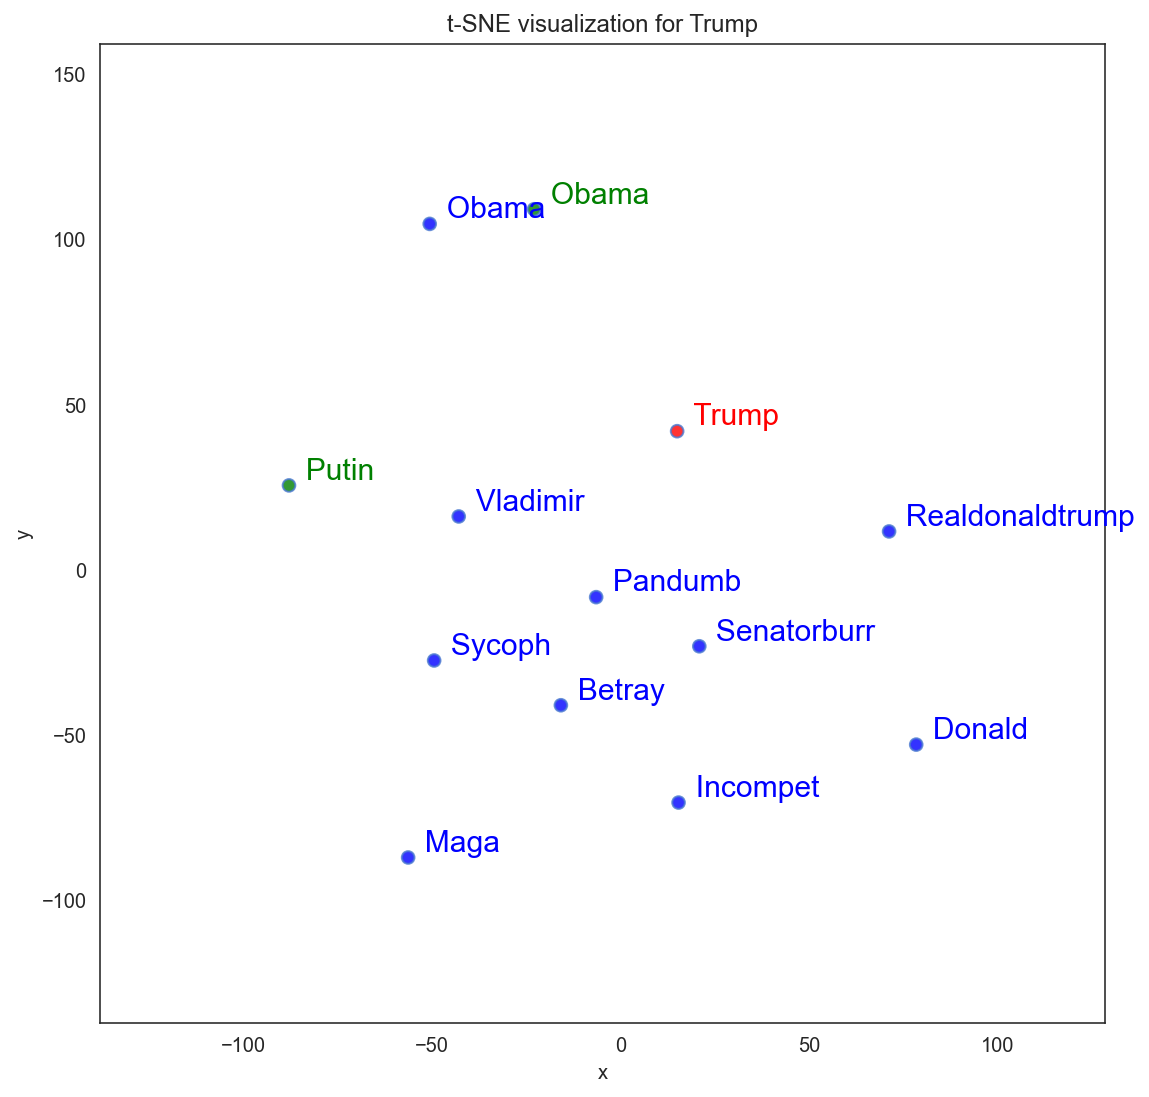

In [177]:
tsnescatterplot(model_w2v, 'trump', ['obama', 'putin'])

### `Result`

In [30]:
# for gensim.models.doc2vec
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size)) # one row with 200 zeroes
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary                                     
            continue
    if count != 0:
        vec /= count
    return vec

In [31]:
wordvec_arrays = np.zeros((len(tokenized_tweets), 200)) 
for i in range(len(tokenized_tweets)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweets[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays) 

wordvec_df.shape    

(20229, 200)

In [157]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.105914,-0.002841,-0.192273,-0.148919,-0.271315,0.044143,-0.022043,-0.176830,0.109201,0.208632,...,0.023172,-0.162828,0.029619,0.062139,-0.089745,-0.059033,-0.030076,-0.115900,0.011097,0.302937
1,-0.094330,-0.155115,-0.103709,-0.134786,-0.214377,0.230180,0.042967,-0.240493,0.049412,0.044875,...,-0.064790,-0.083339,-0.122424,-0.215897,0.131422,-0.171045,0.000914,0.097224,0.004500,0.284665
2,0.044747,-0.205585,-0.015473,0.004346,-0.113369,-0.110285,-0.071472,-0.285461,0.235023,0.187015,...,-0.048040,0.005841,0.072534,-0.130350,-0.062027,-0.142509,-0.047941,-0.176285,0.283444,0.182974
3,-0.010197,-0.180539,-0.016813,-0.112009,-0.274149,0.050402,0.029439,-0.142704,0.187684,0.054706,...,-0.099990,-0.197581,-0.111999,-0.006706,0.064337,0.013209,-0.091088,-0.104703,0.115503,0.061607
4,-0.135774,-0.166038,0.003787,-0.219263,-0.123648,0.043973,-0.106927,-0.160625,0.162334,0.080601,...,-0.057493,0.140049,-0.144832,-0.131001,0.056910,0.133148,-0.126351,-0.291452,0.155236,0.243122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20224,0.103015,-0.178124,-0.041178,0.061179,-0.102975,-0.090687,0.044540,-0.158655,0.212657,-0.049915,...,0.014561,-0.064668,-0.114898,-0.191186,0.113728,-0.059027,-0.048114,-0.141147,0.118416,0.187811
20225,0.019690,-0.153681,-0.168807,-0.048256,-0.228647,0.166390,-0.047818,-0.078066,0.097741,0.237531,...,-0.043737,-0.167181,0.034842,-0.118599,0.027504,-0.059644,-0.277511,-0.086127,0.269785,0.154248
20226,0.011967,-0.171520,0.052762,0.034557,-0.168226,0.077975,-0.038364,-0.050331,-0.007875,0.143439,...,-0.014829,-0.106632,0.046544,-0.167571,0.090032,0.007836,0.023569,-0.163697,0.203192,0.074025
20227,-0.003382,-0.249078,-0.029472,0.079041,-0.225750,-0.067055,-0.200002,-0.113652,0.133445,0.174053,...,-0.058432,-0.137870,-0.095209,-0.151052,0.025961,-0.003090,0.013231,-0.246614,0.219683,0.242901


### `Test Sample`

In [431]:
X_test['CleanTweet'].reset_index().drop(columns = 'ID')['CleanTweet']

0       rough weekend albert heijn supermarket restock...
1       #coronavirusoutbreak #cdc #covid groceri store...
2       dear sethi have thought bank employe home loan...
3       everyon worri about #coronaviru #toiletpap thi...
4       covid scam target deposit account rampant join...
                              ...                        
6739       groceri store #coronaviru tip point http suenv
6740    #paracetamol first line medicin cure #coronavi...
6741    covid wind turbin price increas renew renew en...
6742    way hacker scammer exploit panic espionag comm...
6743    instead hear more about selfish panick terribl...
Name: CleanTweet, Length: 6744, dtype: object

In [446]:
tokenized_tweets = X_test['CleanTweet'].reset_index().drop(columns = 'ID')['CleanTweet'].apply(lambda x: x.split())

In [447]:
wordvec_arrays = np.zeros((len(tokenized_tweets), 200)) 
for i in range(len(tokenized_tweets)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweets[i], 200)
    wordvec_df_test = pd.DataFrame(wordvec_arrays) 

wordvec_df_test.shape   

(6744, 200)

### Pipeline `XGBClassifier`

In [427]:
pipeline = Pipeline(steps = [('XGBClassifier', XGBClassifier(max_depth=6, n_estimators=700, nthread= 3))])

In [429]:
%%time
pipeline.fit(wordvec_df, y_train_num)

tf_pred = pipeline.predict(wordvec_df)
tf_pred_test = pipeline.predict(wordvec_df_test)

CPU times: user 1h 20min 20s, sys: 18.9 s, total: 1h 20min 39s
Wall time: 28min 47s


## 5.2. `XGBClassifier()` & `CountVectorizer()`

**Note:** 5.3. `GridSearch()` for `XGBClassifier()` & `CountVectorizer()` determined optimal parameters:

* xgb_learning_rate: 0.4
* xgb_max_depth: 5
* xgb_n_estimators: 600

In [32]:
pipeline = Pipeline(steps = [('count_vec', CountVectorizer(stop_words="english", 
                                                           analyzer='word', 
                                                           ngram_range=(1, 3), 
                                                           max_df=1.0, 
                                                           min_df=1, 
                                                           max_features=None)),
                             
                            ('XGBClassifier', XGBClassifier(max_depth=5, 
                                                            n_estimators=600, 
                                                            learning_rate = 0.4, 
                                                            nthread= 3))])

In [33]:
%%time
pipeline.fit(X_train.CleanTweet, y_train_num)

tf_pred_train = pipeline.predict(X_train.CleanTweet)
tf_pred_test = pipeline.predict(X_test.CleanTweet)

KeyboardInterrupt: 

## 5.3. `GridSearch()` for `XGBClassifier()` & `CountVectorizer()`

In [85]:
%%time
params_grid = dict(xgb_learning_rate = [0.2, 0.3, 0.4], n_estimators = [600, 700, 800])

results = []

for params in tqdm(ParameterGrid(params_grid)):
    
    pipeline = Pipeline(steps = [('count_vec', CountVectorizer(stop_words="english", 
                                                               analyzer='word', 
                                                               ngram_range=(1, 3), 
                                                               max_df=1.0, 
                                                               min_df=1, 
                                                               max_features=None)),

                                ('XGBClassifier', XGBClassifier(max_depth=5, 
                                                                n_estimators = params['n_estimators'], 
                                                                learning_rate = params['xgb_learning_rate'], 
                                                                nthread= 3))])
    
    
    
    
    pipeline.fit(X_train.CleanTweet, y_train_num)
    
    pipe_preds_train = pipeline.predict(X_train.CleanTweet)
    pipe_preds_test = pipeline.predict(X_test.CleanTweet)
    
    results.append(dict(
        
        params=params,
        
        precision_train = precision_score(y_true=y_train_num, y_pred=pipe_preds_train, average='macro'),
        precision_test = precision_score(y_true=y_test_num, y_pred=pipe_preds_test, average='macro'),       
        
        recall_train = recall_score(y_true=y_train_num, y_pred=pipe_preds_train, average='macro'),
        recall_test = recall_score(y_true=y_test_num, y_pred=pipe_preds_test, average='macro'),
        
        f1_train = f1_score(y_true=y_train_num, y_pred=pipe_preds_train, average='macro'),
        f1_test = f1_score(y_true=y_test_num, y_pred=pipe_preds_test, average='macro'),
    
        accuracy_train = accuracy_score(y_true=y_train_num, y_pred=pipe_preds_train),
        accuracy_test = accuracy_score(y_true=y_test_num, y_pred=pipe_preds_test)
    ))
results


100%|██████████████████████████████████████████| 9/9 [1:08:36<00:00, 457.37s/it]

CPU times: user 3h 20min 17s, sys: 37.8 s, total: 3h 20min 55s
Wall time: 1h 8min 36s


[{'params': {'n_estimators': 600, 'xgb_learning_rate': 0.2},
  'precision_train': 0.8602533579511242,
  'precision_test': 0.5978361276185351,
  'recall_train': 0.8475135214983179,
  'recall_test': 0.588493539987323,
  'f1_train': 0.8503720174538696,
  'f1_test': 0.5885371524470866,
  'accuracy_train': 0.8440852241831035,
  'accuracy_test': 0.5802194543297746},
 {'params': {'n_estimators': 600, 'xgb_learning_rate': 0.3},
  'precision_train': 0.9001055763896986,
  'precision_test': 0.6048107721191295,
  'recall_train': 0.8928411392053043,
  'recall_test': 0.5970870245784513,
  'f1_train': 0.8943356042084872,
  'f1_test': 0.5973396550949013,
  'accuracy_train': 0.8889218448761679,
  'accuracy_test': 0.5876334519572953},
 {'params': {'n_estimators': 600, 'xgb_learning_rate': 0.4},
  'precision_train': 0.9274101402726747,
  'precision_test': 0.6078354476196175,
  'recall_train': 0.9222275301428319,
  'recall_test': 0.5979508286083149,
  'f1_train': 0.9233662937579646,
  'f1_test': 0.5993820

In [86]:
results = pd.DataFrame(results)
results.sort_values('accuracy_test', ascending=False).head(10).style.bar(vmin=0, vmax=1)

,params,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test
2,"{'n_estimators': 600, 'xgb_learning_rate': 0.4}",0.927410,0.607835,0.922228,0.597951,0.923366,0.599382,0.918978,0.591934
7,"{'n_estimators': 800, 'xgb_learning_rate': 0.3}",0.928269,0.606927,0.923561,0.598282,0.924467,0.599298,0.920164,0.590451
5,"{'n_estimators': 700, 'xgb_learning_rate': 0.4}",0.941597,0.605946,0.938497,0.596146,0.938943,0.597887,0.935439,0.590006
4,"{'n_estimators': 700, 'xgb_learning_rate': 0.3}",0.916908,0.607280,0.910702,0.597497,0.912059,0.598907,0.907212,0.589858
8,"{'n_estimators': 800, 'xgb_learning_rate': 0.4}",0.950880,0.603013,0.948917,0.595077,0.949017,0.596288,0.945969,0.588820
6,"{'n_estimators': 800, 'xgb_learning_rate': 0.2}",0.888728,0.605992,0.879063,0.596220,0.881204,0.597030,0.875772,0.588227
1,"{'n_estimators': 600, 'xgb_learning_rate': 0.3}",0.900106,0.604811,0.892841,0.597087,0.894336,0.597340,0.888922,0.587633
3,"{'n_estimators': 700, 'xgb_learning_rate': 0.2}",0.875101,0.602057,0.863566,0.591748,0.866265,0.592442,0.860497,0.583926
0,"{'n_estimators': 600, 'xgb_learning_rate': 0.2}",0.860253,0.597836,0.847514,0.588494,0.850372,0.588537,0.844085,0.580219


## 5.4.  Evaluation on the Train Sample & the Test Sample

In [72]:
print(classification_report(y_true=y_train_num, y_pred=tf_pred_train))
print('Balanced accuracy:', round(balanced_accuracy_score (y_true=y_train_num, y_pred=tf_pred_train), 3))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2751
           1       0.95      0.90      0.92      4899
           2       0.85      0.97      0.91      3733
           3       0.94      0.93      0.94      5584
           4       0.99      0.95      0.97      3262

    accuracy                           0.94     20229
   macro avg       0.94      0.94      0.94     20229
weighted avg       0.94      0.94      0.94     20229

Balanced accuracy: 0.938


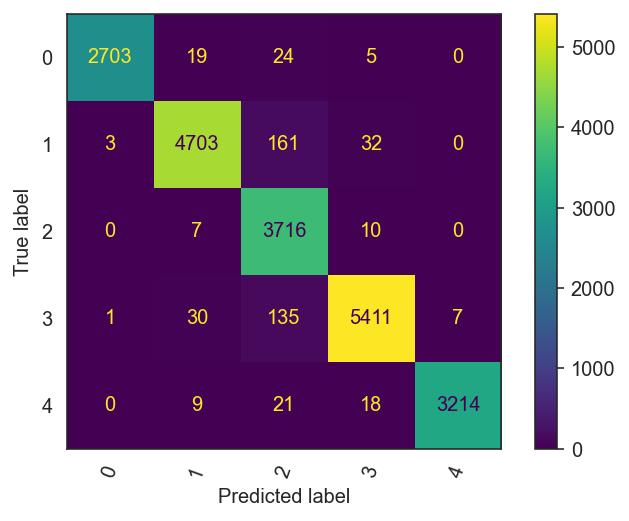

In [529]:
ConfusionMatrixDisplay.from_predictions(y_true=y_train_num, y_pred=tf_pred_train)
plt.xticks(rotation=70)
plt.show()

In [73]:
print(classification_report(y_true=y_test_num, y_pred=tf_pred_test))
print('Balanced accuracy:', round(balanced_accuracy_score (y_true=y_test_num, y_pred=tf_pred_test), 3))

              precision    recall  f1-score   support

           0       0.65      0.55      0.60       917
           1       0.52      0.49      0.50      1634
           2       0.63      0.77      0.69      1244
           3       0.54      0.58      0.56      1862
           4       0.69      0.60      0.64      1087

    accuracy                           0.59      6744
   macro avg       0.61      0.60      0.60      6744
weighted avg       0.59      0.59      0.59      6744

Balanced accuracy: 0.596


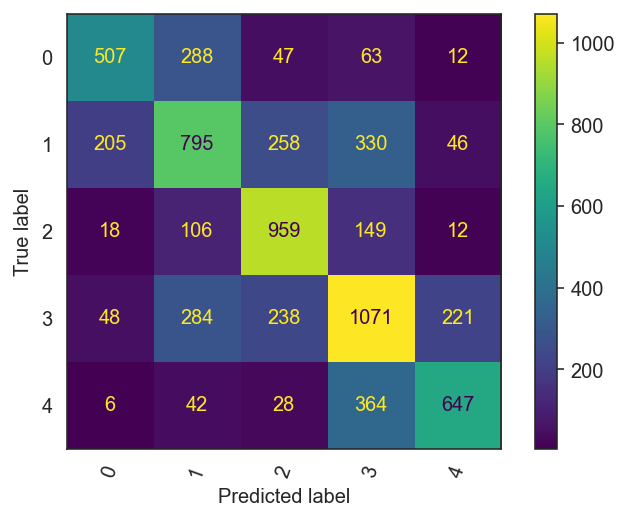

In [74]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test_num, y_pred=tf_pred_test)
plt.xticks(rotation=70)
plt.show()

# 6. Whole Sample training

## `X` & `y` 

**Note:** after choosing an optimal model on the `corona_train.csv` splitting base, let's implement it on the `corona_test.csv`!

In [22]:
%%time
pipeline.fit(X.CleanTweet, y_num)

tf_pred = pipeline.predict(X.CleanTweet)

CPU times: user 25min 54s, sys: 4.96 s, total: 25min 59s
Wall time: 8min 49s


In [23]:
print(classification_report(y_true=y_num, y_pred=tf_pred))
print('Balanced accuracy:', round(balanced_accuracy_score (y_true=y_num, y_pred=tf_pred), 3))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3668
           1       0.91      0.85      0.88      6533
           2       0.80      0.94      0.86      4977
           3       0.89      0.89      0.89      7446
           4       0.97      0.92      0.94      4349

    accuracy                           0.90     26973
   macro avg       0.91      0.90      0.90     26973
weighted avg       0.90      0.90      0.90     26973

Balanced accuracy: 0.901


# 7. `test_data`

## 7.1. Dataset & Missing values

In [24]:
test_data = pd.read_csv('corona_test.csv', encoding='ISO-8859-1', index_col=0)
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet
ID,,,,,
0,36853,81805,NaN,07-04-2020,https://t.co/2yMUPatIYU Wear a mask! Especiall...
1,37363,82315,NaN,08-04-2020,"In light of Covid-19, Canada's insurers are re..."
2,36506,81458,5280,07-04-2020,@ate_ted @SenTedCruz Supply &amp; Demand. COVI...
3,17051,62003,"Sydney, New South Wales",21-03-2020,Around 9 million people die of hunger and hung...
4,41636,86588,India,11-04-2020,Alarming but informative video everyone should...


In [390]:
test_data.shape

(17982, 5)

In [ ]:
# percentage of missing data
(test_data.isna().sum() / len(test_data)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

## 7.2. Data types & Prepsocessing & Converting

In [25]:
# converting to string
test_data.UserName = test_data.UserName.astype(str)
test_data.ScreenName = test_data.ScreenName.astype(str)
test_data.TweetAt = pd.to_datetime(test_data.TweetAt)

In [26]:
test_data['month'] = test_data.TweetAt.dt.month
test_data['day'] = test_data.TweetAt.dt.day
test_data['dayofweek'] = test_data.TweetAt.dt.dayofweek
test_data['weekday'] = test_data.TweetAt.dt.weekday
test_data['tweetlength'] = test_data.OriginalTweet.str.len()

### `CleanTweet`

In [28]:
# for checking 
test_data['CleanTweet'][5]

'disrupt global supplychain be felt across world thank covid pandem recent week demand groceri item deliveri those item surg coronaviru wyijfwyen'

In [27]:
# cleaning
test_data['CleanTweet'] = test_data['OriginalTweet'].str.lower()

test_data['CleanTweet'] = test_data['CleanTweet'].str.replace("[^a-zA-Z#]", " ") # base
test_data['CleanTweet'] = test_data['CleanTweet'].apply(lambda x: x.replace('\n', ' ')) # base

test_data['CleanTweet'] = test_data['CleanTweet'].str.replace('[^A-Za-z0-9]+',' ', regex=True) # kaggle
test_data['CleanTweet'] = test_data['CleanTweet'].str.replace(r"http\S+", "", regex=True) # kaggle

test_data['CleanTweet'] = np.vectorize(remove_pattern)(test_data['CleanTweet'], "@[\w]*") # git
test_data['CleanTweet'] = test_data['CleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) # git

# stemming
tokenized_tweets = test_data['CleanTweet'].apply(lambda x: x.split()) 
stemmer = PorterStemmer() 
tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x]) 

for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])   
test_data['CleanTweet'] = tokenized_tweets

## 7.3. Prediction on `test_data`

In [31]:
tf_pred_test_data = pipeline.predict(test_data.CleanTweet)

In [32]:
tf_pred_test_data

array([4, 3, 1, ..., 2, 4, 3])

**Note:** before submitting, let's convert back 5-classes numeric labels to the text ones.

In [33]:
submission = pd.DataFrame(data = tf_pred_test_data, index = test_data.index,
             columns=['Sentiment']).replace({0: 'Extremely Negative',
                   1: 'Negative',
                   2: 'Neutral',
                   3: 'Positive',
                   4: 'Extremely Positive'})
submission

,Sentiment
ID,
0,Extremely Positive
1,Positive
2,Negative
3,Extremely Negative
4,Extremely Positive
...,...
17977,Positive
17978,Neutral
17979,Neutral


In [34]:
submission.to_csv('submission.csv')